# Data

In [1]:
%%shell
mkdir /root/.kaggle
mv ./kaggle.json /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c mercari-price-suggestion-challenge
7za e train.tsv.7z
7za e test.tsv.7z

 87% 65.0M/74.3M [00:00<00:00, 76.7MB/s]
100% 74.3M/74.3M [00:00<00:00, 94.6MB/s]
  0% 0.00/7.77M [00:00<?, ?B/s]
100% 7.77M/7.77M [00:00<00:00, 127MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 55.6MB/s]
 82% 28.0M/34.0M [00:00<00:00, 49.3MB/s]
100% 34.0M/34.0M [00:00<00:00, 85.7MB/s]
 96% 283M/294M [00:02<00:00, 156MB/s]
100% 294M/294M [00:02<00:00, 132MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  8% - train.tsv                 13% - train.tsv

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output


In [3]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [74]:
# LOADING THE TRAIN AND TEST DATA
train = pd.read_table("train.tsv")
test = pd.read_table("test.tsv")
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (1482535, 8)
Test Shape: (693359, 7)


# EDA

In [57]:
!pip install pandas_summary

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas_profiling import ProfileReport
from IPython import display

from bokeh.io import output_notebook
from bokeh.models import HoverTool
from pandas_summary import DataFrameSummary
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models.annotations import Title

### Item Price Analysis

In [77]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

[Text(0.5, 1.0, 'Price Distribution')]

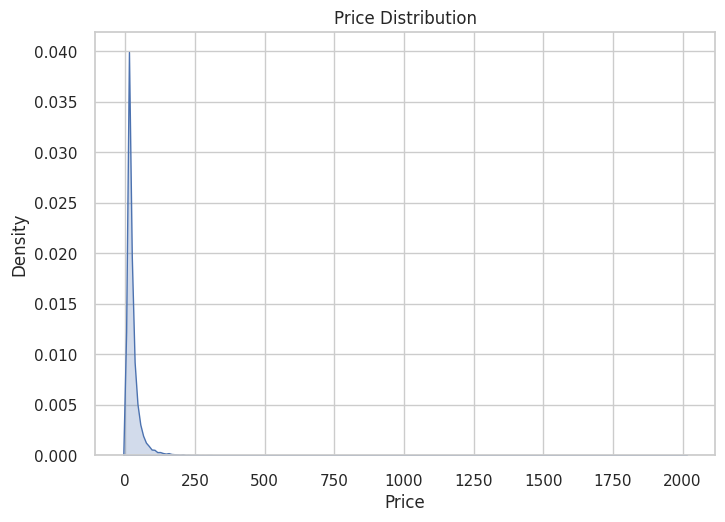

In [78]:
ax = sns.kdeplot(train.price, shade = True)
ax.set(xlabel='Price')
ax.set(title="Price Distribution")
# rightly skewed distribution not uniformly distributed

[Text(0.5, 1.0, 'log1p(Price) Distribution')]

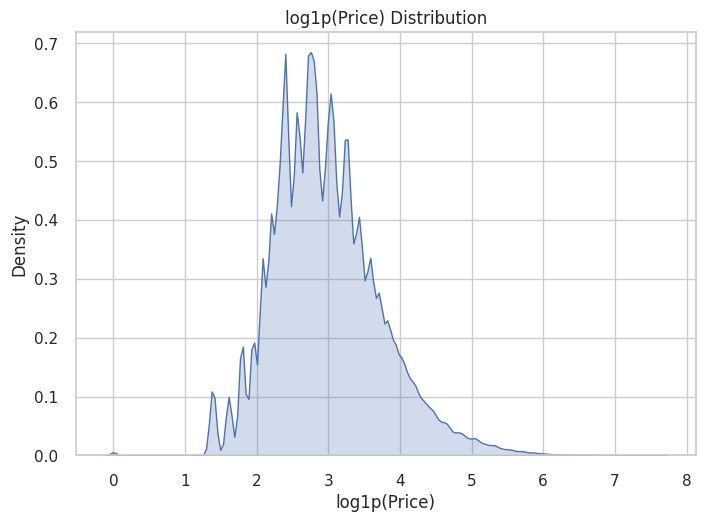

In [79]:
ax = sns.kdeplot(np.log1p(train.price), shade = True)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution")
# need a log distribution to have it uniformly distrubted, it is except right side

### Item Condition Analysis

In [80]:
item_condition_df = pd.DataFrame(train.item_condition_id.value_counts(normalize=True)*100)
item_condition_df

,item_condition_id
1,43.206332
3,29.150138
2,25.326822
4,2.155902
5,0.160806


[Text(0.5, 1.0, 'Products Condition')]

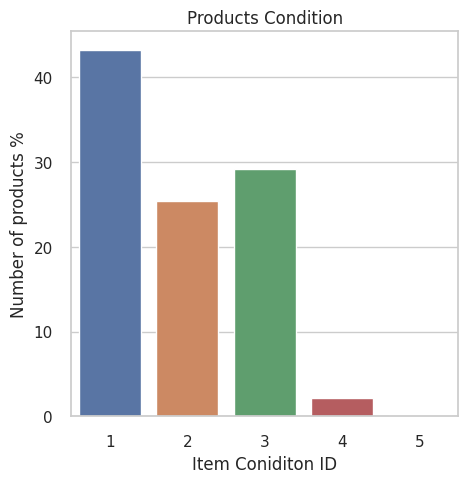

In [81]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
plt.xlabel = "Item Condition"
plt.ylabel = ""
ax = sns.barplot(x=item_condition_df.index, y=item_condition_df.item_condition_id)
ax.set(xlabel='Item Coniditon ID', ylabel='Number of products %')
ax.set(title="Products Condition")

In [82]:
train.item_description[train.item_condition_id==1][:10]

2     Adorable top with a hint of lace and a key hol...
3     New with tags. Leather horses. Retail for [rm]...
4             Complete with certificate of authenticity
11    (5) new vs pink body mists (2.5 oz each) Fresh...
13                                   No description yet
15    Brand new. Deluxe travel size products. Contai...
16    2 glitter eyeshadows; one in Brass and one in ...
17    Brand new in box Size: Medium Color: Coral Ret...
18    This AUTHENTIC pallete by Too Faced is brand n...
21    NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...
Name: item_description, dtype: object

In [83]:
train.item_description[train.item_condition_id==5][:10]

258     Powers on, no screen display, no external dama...
653                                    No description yet
1027                 10k gold 18" chain. Broken at clasp.
2436    For parts . Turns on and hold battery charge ....
2803    2 pounds of junk jewelry, There are some items...
3177                                   No description yet
3394                                  For parts or repair
4948         moving out so just dont wanna keep For Free！
5055                      Powers on but won't play games.
5938    Alex and ani rafaelian gold set of four bracel...
Name: item_description, dtype: object

### Item Shipping Analysis

In [84]:
#shipping condition
shipping_df = pd.DataFrame(train.shipping.value_counts(normalize=True)*100)
shipping_df

,shipping
0,55.272557
1,44.727443


[Text(0.5, 1.0, 'Products Shipping')]

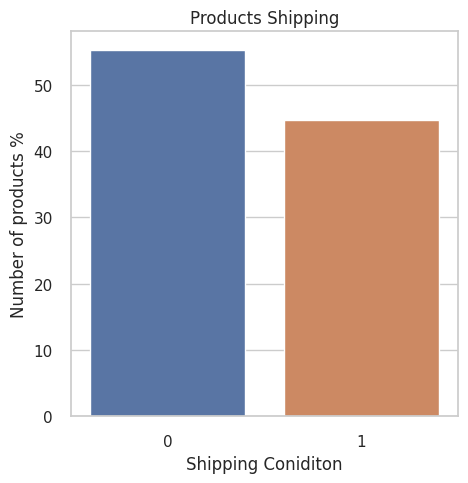

In [85]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
ax = sns.barplot(x=shipping_df.index, y=shipping_df.shipping)
ax.set(xlabel='Shipping Coniditon', ylabel='Number of products %')
ax.set(title="Products Shipping")

In [86]:
# price analysis for different shipping conditions
train.groupby('shipping').price.mean()

shipping
0    30.111778
1    22.567726
Name: price, dtype: float64

In [87]:
seller_shipping= train.loc[train.shipping==1].price
not_seller_shipping = train.loc[train.shipping==0].price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'log1p(Price) Distribution for different shipping conditions')]

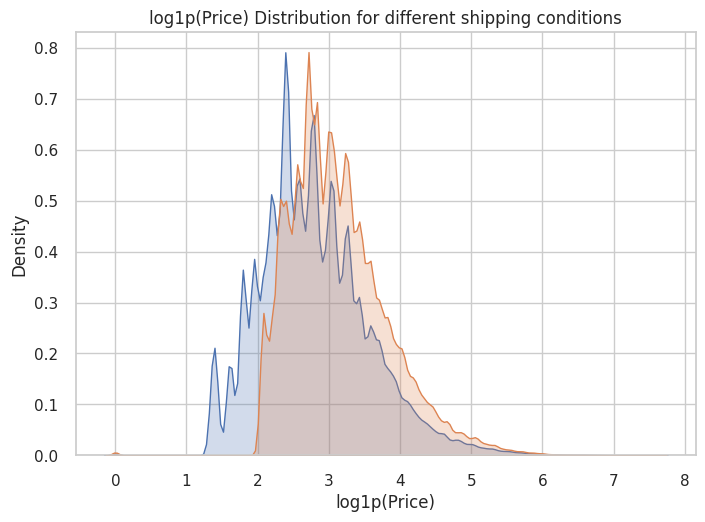

In [88]:
ax = sns.kdeplot(np.log1p(seller_shipping),label="shipping: 1",
                   shade=True, shade_lowest=False)
ax = sns.kdeplot(np.log1p(not_seller_shipping),label="shipping: 0",
                   shade=True, shade_lowest=False)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution for different shipping conditions")

### Item Brand Name Analysis

In [89]:
train.brand_name.nunique()

4809

In [90]:
brand_names_list = list(train.brand_name.unique())
brand_names_list[:20]

[nan,
 'Razer',
 'Target',
 'Acacia Swimwear',
 'Soffe',
 'Nike',
 'Smashbox',
 "Victoria's Secret",
 'rue',
 'Scholastic',
 'UGG Australia',
 'Tarte',
 'Wet n Wild',
 'Too Faced',
 'Anthropologie',
 'Torrid',
 'Samsung',
 'FOREVER 21',
 'Air Jordan',
 'Apple']

In [91]:
#43% values contain NaNs, top most frequent brands from remaining 57% data are
train.brand_name.value_counts(normalize=True,dropna=True).nlargest(10)*100

PINK                 6.364395
Nike                 6.359100
Victoria's Secret    5.652272
LuLaRoe              3.650514
Apple                2.038235
FOREVER 21           1.786897
Nintendo             1.765835
Lululemon            1.713002
Michael Kors         1.638872
American Eagle       1.559564
Name: brand_name, dtype: float64

[Text(0.5, 1.0, 'Most Expensive Brands')]

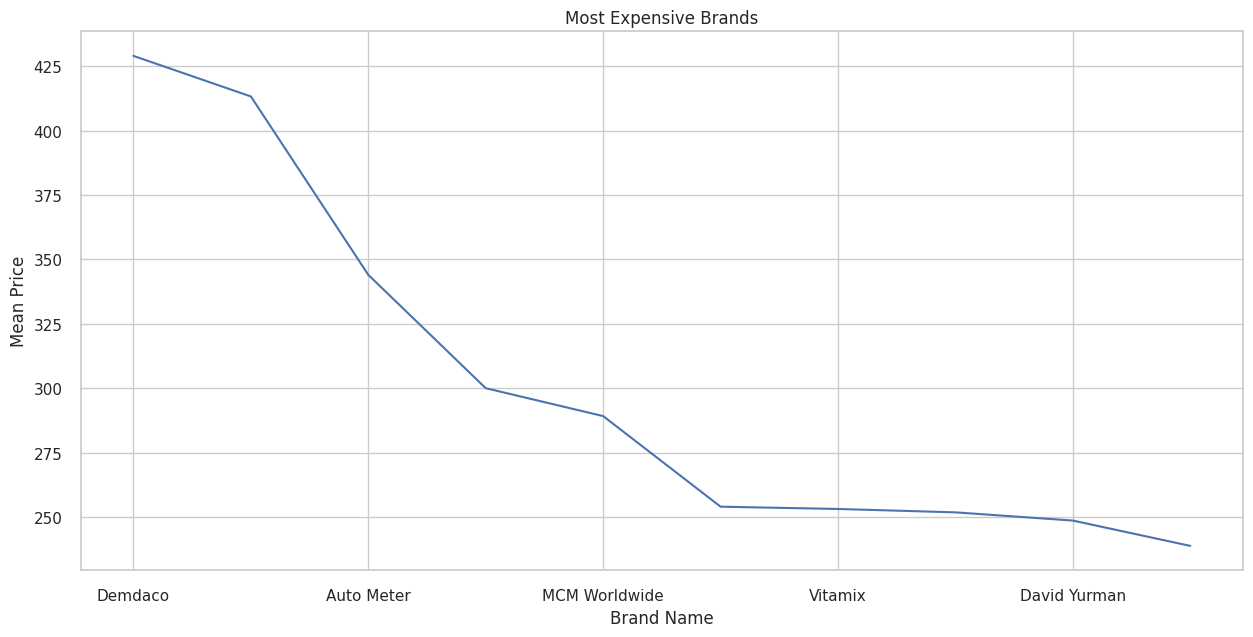

In [92]:
## most expensive brands
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['brand_name']).mean()['price'].nlargest(10).plot(ax=ax)
ax.set(xlabel='Brand Name', ylabel='Mean Price')
ax.set(title="Most Expensive Brands")

### Item Category Analysis

In [94]:
train.category_name.nunique()

1287

In [95]:
train['category_name'].value_counts(normalize=True)[:10]*100

Women/Athletic Apparel/Pants, Tights, Leggings                 4.076458
Women/Tops & Blouses/T-Shirts                                  3.141834
Beauty/Makeup/Face                                             2.325892
Beauty/Makeup/Lips                                             2.026137
Electronics/Video Games & Consoles/Games                       1.799001
Beauty/Makeup/Eyes                                             1.708093
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    1.671580
Women/Underwear/Bras                                           1.441125
Women/Tops & Blouses/Blouse                                    1.374061
Women/Tops & Blouses/Tank, Cami                                1.374061
Name: category_name, dtype: float64

In [96]:
train.groupby(train.category_name.str.count("/")).count()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
category_name,,,,,,,,
2.0,1471819,1471819,1471819,1471819,844461,1471819,1471819,1471815
3.0,1330,1330,1330,1330,372,1330,1330,1330
4.0,3059,3059,3059,3059,2150,3059,3059,3059


In [97]:
# extract categories
train["category_L1"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+", expand=False)
train["category_L2"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+", expand=False)
train["category_L3"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)", expand=False)

In [99]:
category_L1_df = pd.DataFrame(train.category_L1.value_counts(normalize=True,dropna=False)*100)
category_L1_df

,category_L1
Women,44.814119
Beauty,14.018421
Kids,11.580772
Electronics,8.275690
Men,6.318906
Home,4.578037
Vintage & Collectibles,3.138543
Other,3.059017
Handmade,2.080356
Sports & Outdoors,1.709369


[Text(0.5, 1.0, 'Main Categories')]

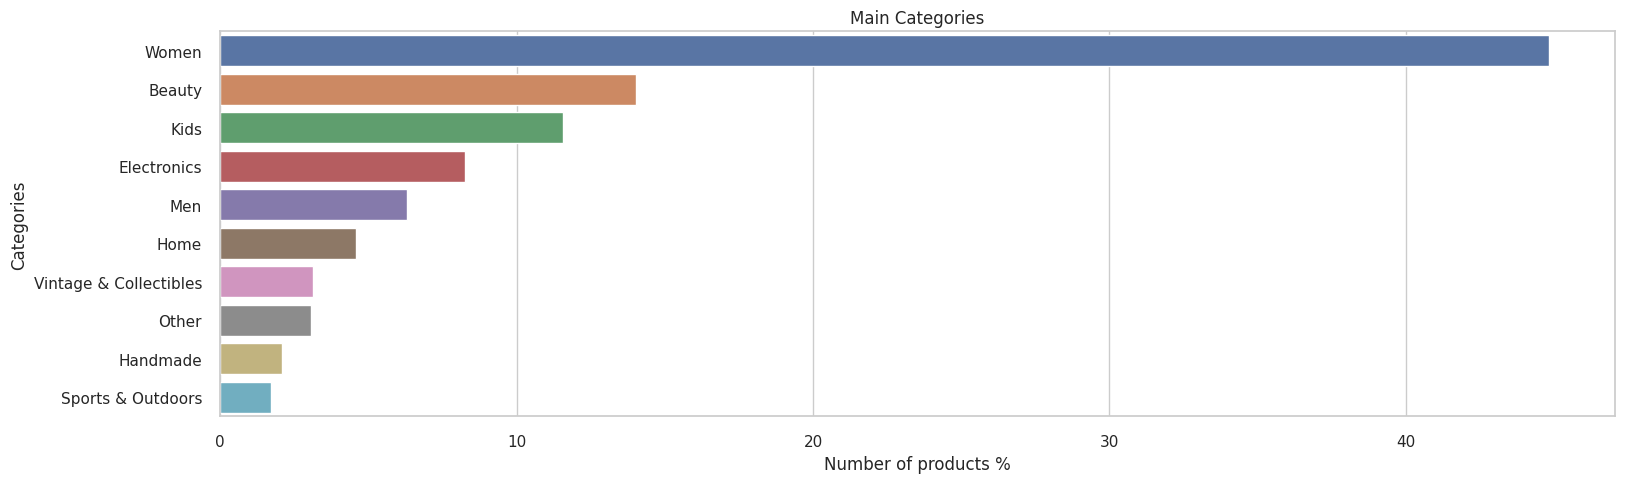

In [100]:
sns.set(style="whitegrid")
plt.subplots(figsize=(18,5))
ax = sns.barplot(y=category_L1_df.index, x=category_L1_df.category_L1)
ax.set(xlabel='Number of products %', ylabel='Categories')
ax.set(title="Main Categories")

In [103]:
train.category_L1.nunique()

10

In [101]:
train.category_L2.nunique()

113

In [102]:
train.category_L3.nunique()

870

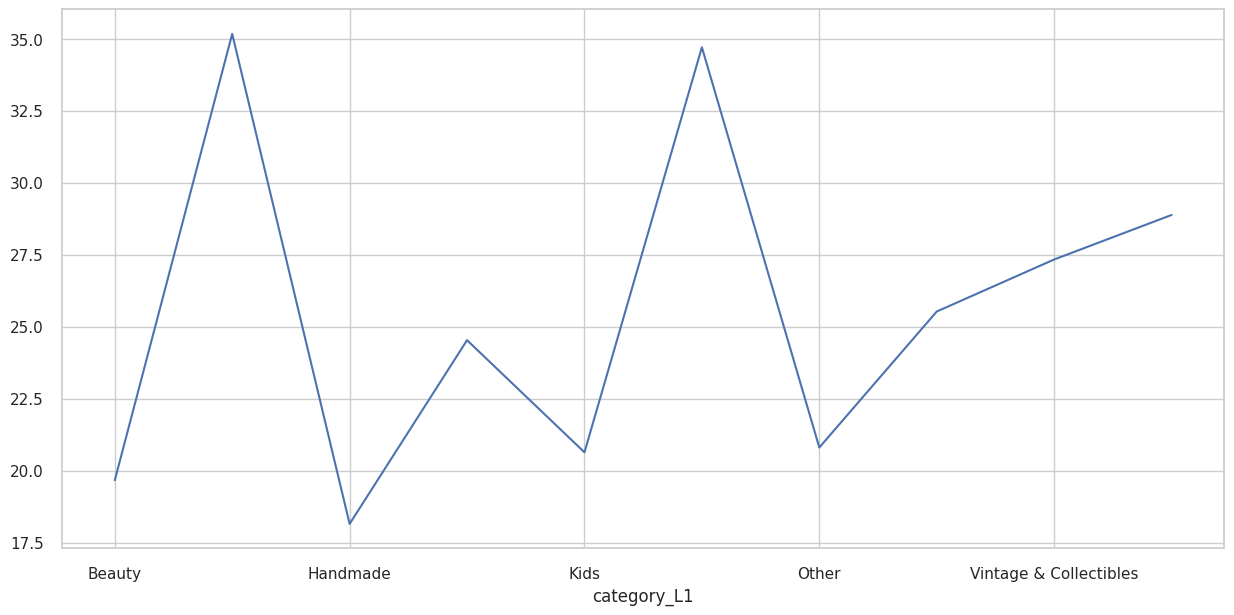

In [104]:
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['category_L1'])['price'].mean().plot(ax=ax)

In [105]:
free_products = train[train.price==0]
free_products.shape[0]

874

# Data Preprocessing

In [8]:
# HANDLING THE MISSING VALUES FOR TRAINING AND TESTING DATA BY REPLACING VALUES WITH MISSING
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)


In [12]:
# PROCESSING THE CATEGORICAL DATA USING THE LABEL ENCODER
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity


In [13]:
# PROCCESSING THE TEXT USING TOKENIZER
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

# Creates the vocabulary index based on the word frequency using the raw text
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

# Transforms the training and testing item_descriptions and names to a sequence of integers
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...,"[5, 9, 61, 178, 6528, 230, 3, 21, 166, 1085, 2...","[178, 2610, 14248]"
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity,"[807, 9, 6888, 11, 1997]","[4884, 104, 1032, 280]"


In [14]:
# ANALYZING THE SEQUENCE VARIABLES ITEM NAME AND ITEM DESCRIPTION
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("Maximum Name Sequence: "+str(max_name_seq))
print("Maximum Item Description: "+str(max_seq_item_description))

Maximum Name Sequence: 17
Maximum Item Description: 269


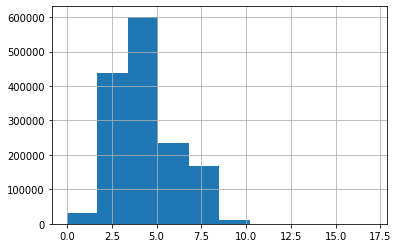

In [17]:
train.seq_name.apply(lambda x: len(x)).hist()


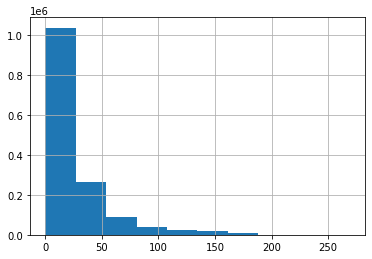

In [18]:
train.seq_item_description.apply(lambda x: len(x)).hist()


In [19]:
# EMBEDDINGING THE MAX VALUE
# Based on the histogram plors the next lengths are selected
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01a1aa2290>]],
      dtype=object)

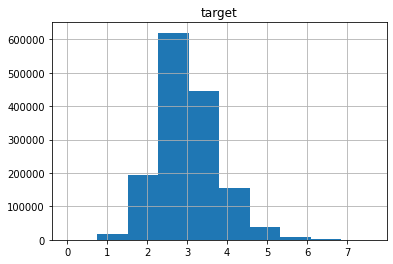

In [20]:
# SCALING THE TAREGT VARIABLE (PRICE) USING MINMAXSCALER TO THE RANGE OF 0 AND 1
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
pd.DataFrame(train.target).hist()

In [22]:
# USING TRAIN TEST SPLIT IN ORDER TO GET OUR TRAIN AND VALIDATION DATA FROM THE TRAINING DATA
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print("Train Set Shape:", dtrain.shape)
print("Validation Set Shape:", dvalid.shape)

Train Set Shape: (1467709, 11)
Validation Set Shape: (14826, 11)


In [23]:
# FUNCTION TO GET KERAS DATA
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

# Models and Results

### Recurrent Neural Network (RNN)

In [43]:
# CREATING THE NECESSARY FUNCTIONS FOR THE RNN MODEL
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_rnn_model():
    # Parameters
    dr_r = 0.1
    
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    # Embedding layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    # RNN layers
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    # Main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output layer
    output = Dense(1, activation="linear") (main_l)
    
    # RNN Model Itself
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_rnn_model()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                            

In [37]:
# FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_rnn_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 23s 243ms/step - loss: 1.8997 - mae: 1.0166 - rmsle_cust: 0.3139 - val_loss: 0.3316 - val_mae: 0.4377 - val_rmsle_cust: 0.1109
Epoch 2/5
74/74 [==============================] - 17s 229ms/step - loss: 0.3234 - mae: 0.4346 - rmsle_cust: 0.1101 - val_loss: 0.2626 - val_mae: 0.3883 - val_rmsle_cust: 0.0987
Epoch 3/5
74/74 [==============================] - 17s 229ms/step - loss: 0.2819 - mae: 0.4041 - rmsle_cust: 0.1025 - val_loss: 0.2482 - val_mae: 0.3762 - val_rmsle_cust: 0.0957
Epoch 4/5
74/74 [==============================] - 17s 231ms/step - loss: 0.2627 - mae: 0.3892 - rmsle_cust: 0.0988 - val_loss: 0.2413 - val_mae: 0.3699 - val_rmsle_cust: 0.0942
Epoch 5/5
74/74 [==============================] - 17s 229ms/step - loss: 0.2491 - mae: 0.3785 - rmsle_cust: 0.0961 - val_loss: 0.2371 - val_mae: 0.3672 - val_rmsle_cust: 0.0935


In [34]:
# EVALUATING THE RNN MODEL ON VALIDATION
def eval_model(model):
    val_preds = model.predict(X_valid)
    val_preds = np.exp(val_preds)+1

    y_true = np.array(dvalid.price.values)
    y_pred = val_preds[:,0]
    v_rmsle = rmsle(y_true, y_pred)
    print(" RMSLE error on validation set: "+str(v_rmsle))

eval_model(model)

 RMSLE error on validation set: 0.4987420711074355


### Convolutionary Neural Network (CNN)

In [49]:
def get_cnn_model():  
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    # Embedding layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    # CNN layers
    convs1 = []
    convs2 = []
    
    for filter_length in [1,2]:
        cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_name)
        cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_desc)
        
        maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
        maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
        
        convs1.append(maxpool1)
        convs2.append(maxpool2)

    convs1 = concatenate(convs1)
    convs2 = concatenate(convs2)
    
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , convs1
        , convs2
        , num_vars
    ])

    # Main layer
    main_l = Dropout(0.25)(Dense(128, activation='relu') (main_l)) 
    main_l = Dropout(0.1)(Dense(64, activation='relu') (main_l)) 

    # Output layer    
    output = Dense(1, activation='linear') (main_l)

     # CNN Model Itself
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss='mse', optimizer='adam', metrics=["mae", rmsle_cust])
    
    return model

model = get_cnn_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name (InputLayer)              [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_65 (Embedding)       (None, 10, 50)       12954400    ['name[0][0]']                   
                                                                                                  
 embedding_66 (Embedding)       (None, 75, 50)       12954400    ['item_desc[0][0]']              
                                                                                            

In [50]:
# FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_rnn_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 23s 244ms/step - loss: 1.7489 - mae: 0.9649 - rmsle_cust: 0.2931 - val_loss: 0.3146 - val_mae: 0.4262 - val_rmsle_cust: 0.1080
Epoch 2/5
74/74 [==============================] - 17s 230ms/step - loss: 0.3119 - mae: 0.4259 - rmsle_cust: 0.1079 - val_loss: 0.2578 - val_mae: 0.3837 - val_rmsle_cust: 0.0976
Epoch 3/5
74/74 [==============================] - 17s 230ms/step - loss: 0.2748 - mae: 0.3984 - rmsle_cust: 0.1011 - val_loss: 0.2441 - val_mae: 0.3726 - val_rmsle_cust: 0.0948
Epoch 4/5
74/74 [==============================] - 17s 230ms/step - loss: 0.2559 - mae: 0.3840 - rmsle_cust: 0.0975 - val_loss: 0.2383 - val_mae: 0.3683 - val_rmsle_cust: 0.0938
Epoch 5/5
74/74 [==============================] - 17s 231ms/step - loss: 0.2436 - mae: 0.3741 - rmsle_cust: 0.0951 - val_loss: 0.2351 - val_mae: 0.3658 - val_rmsle_cust: 0.0932


In [51]:
eval_model(model)

 RMSLE error on validation set: 0.4970432530624077


# Conclusion

Using both RNN and CNN, it becomes evident that the CNN model performs better with a RMSLE lower than that of the RNN model.  However, the CNN model's RMSLE error is only slightly smaller than that of the RNN model.